Tumblr Api Data Collection


In [2]:
!pip install pytumblr


^C


In [1]:
import pytumblr

In [2]:
keysfile = open("/home/mel/Desktop/repos/cottagecore_tradfem_pipeline/keys.txt", "r")
keys = keysfile.readlines()


client = pytumblr.TumblrRestClient(
    keys[0].strip(),
    keys[1].strip(),
    keys[0].strip(),
    keys[1].strip(),
)

In [3]:
# need to do multiple queries to get more than 20 posts, grab 20 from consecutive 5 hours blocks
import time


def searchtags(num_posts, tag):
    """
    num_posts is number of posts to fetch
    tag is what tag to search
    returns a list of results
    """
    num_requests = round(num_posts / 20)
    # first timestamp should be 5*num_requests hours before current timestamp
    current_time = int(time.time())
    sample_time_length = (
        18000  # this is how many seconds in between samples, here it is 5 hours
    )
    sample_time = current_time - num_requests * sample_time_length
    results = []
    i = 0
    while i < num_requests:
        results = results + client.tagged(tag=tag, before=sample_time)
        i = i + 1
        sample_time = sample_time + sample_time_length
    return results

In [7]:
cottagecore_posts = searchtags(2000, "cottagecore")  # is this sufficient for labeling?

In [5]:
tradwife_posts = searchtags(2000, "tradwife")

In [8]:
print(len(tradwife_posts))
print(cottagecore_posts[0]["blog_name"])

2000
sirensrjustreallycool


In [27]:
!pip install bs4

  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=2f61d6752f14ff2d1c201c81b4d101538a2d65babbed35e278b85424c000b89e
  Stored in directory: c:\users\melka\appdata\local\pip\cache\wheels\73\2b\cb\099980278a0c9a3e57ff1a89875ec07bfa0b6fcbebb9a8cad3
Successfully built bs4

You should consider upgrading via the 'c:\users\melka\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [66]:
# collecting images from all posts, label with name of user who posted image
import pandas as pd
import requests
import shutil
import os
import sys
from bs4 import BeautifulSoup


def fetch_image(url, filename):
    """
    fetches image at url and saves it with filename
    """
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
        r.raw.decode_content = True
        # Open a local file with wb ( write binary ) permission.
        with open(filename, "wb") as f:
            shutil.copyfileobj(r.raw, f)


def download_images(list_of_posts, foldername):
    """
    function that downloads images from a list of tumblr posts (list_of_posts) and saves them to a folder called foldername. username of poster is in the filename.
    """
    # create folder if not already made
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    for post in list_of_posts:
        # first I need to extract all image urls from json object which are in post['body'] and post['reblog']['comment'] OR post['photos'] photo['original_size']['url']
        poster_url = post["blog_name"]
        i = 0
        if "body" in post:
            # print(post['body'])
            soup = BeautifulSoup(post["body"])
            images = soup.find_all("img")
            for image in images:
                # print("printing image")
                # print(image.get("src"))
                fetch_image(
                    image.get("src"),
                    foldername + "/" + poster_url + "postnum" + str(i) + ".jpg",
                )
                i = i + 1
        elif "photos" in post:
            for photo in post["photos"]:
                # print(photo['original_size']['url'])
                soup = BeautifulSoup(photo["original_size"]["url"])
                images = soup.find_all("img")
                for image in images:
                    # print("printing image")
                    # print(image.get("src"))
                    fetch_image(
                        image.get("src"),
                        foldername + "/" + poster_url + "postnum" + str(i) + ".jpg",
                    )
                    i = i + 1
        if "reblog" in post:
            # print(post['reblog']['comment'])
            soup = BeautifulSoup(post["reblog"]["comment"])
            images = soup.find_all("img")
            for image in images:
                # print("printing image")
                # print(image.get("src"))
                fetch_image(
                    image.get("src"),
                    foldername + "/" + poster_url + "postnum" + str(i) + ".jpg",
                )
                i = i + 1

In [71]:
# print(cottagecore_posts[1])
download_images(cottagecore_posts, "testfolder")

In [72]:
# saving tumblr api info to pickle file
import pickle

with open("cottagecore.pkl", "wb") as f:
    pickle.dump(cottagecore_posts, f)
with open("tradfem.pkl", "wb") as f:
    pickle.dump(tradwife_posts, f)

# data gathered and images downloaded 10.3.2022

Making Pipeline to collect data 

In [53]:
import pickle

with open("1665500636_8.pkl", "rb") as f:
    tradfem_posts = pickle.load(f)

In [54]:
for post in tradfem_posts:
    print(post["date"])

2022-10-11 17:28:51 GMT
2022-10-11 17:28:39 GMT
2022-10-11 17:28:27 GMT
2022-10-11 17:15:08 GMT
2022-10-11 17:08:40 GMT
2022-10-11 17:06:25 GMT
2022-10-11 17:04:02 GMT
2022-10-11 16:41:45 GMT
2022-10-11 16:38:07 GMT
2022-10-11 16:31:29 GMT
2022-10-11 16:30:53 GMT
2022-10-11 16:20:45 GMT
2022-10-11 16:15:30 GMT
2022-10-11 16:14:26 GMT
2022-10-11 15:55:07 GMT
2022-10-11 15:39:41 GMT
2022-10-11 15:34:39 GMT
2022-10-11 15:28:04 GMT
2022-10-11 15:06:50 GMT
2022-10-11 15:03:56 GMT


In [47]:
import pandas
import pandas as pd
import requests
import shutil
import os
import sys
from bs4 import BeautifulSoup

dataframedict = {
    "time_posted": [],
    "blog_name": [],
    "post_id": [],
    "post_type": [],
    "image_urls": [],
    "tags": [],
    "post_url": [],
}


def fetch_image(url, filename):
    """
    fetches image at url and saves it with filename
    """
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
        r.raw.decode_content = True
        # Open a local file with wb ( write binary ) permission.
        with open(filename, "wb") as f:
            shutil.copyfileobj(r.raw, f)


for post in tradfem_posts[0:10]:
    # time posted
    dataframedict["time_posted"].append(post["date"])
    # blog name
    dataframedict["blog_name"].append(post["blog_name"])
    # post id
    dataframedict["post_id"].append(post["id_string"])
    # post type
    dataframedict["post_type"].append(post["type"])
    # image_urls
    # first I need to extract all image urls from json object which are in post['body'] and post['reblog']['comment'] OR post['photos'] photo['original_size']['url']
    image_urls = []
    if "body" in post:
        soup = BeautifulSoup(post["body"])
        images = soup.find_all("img")
        for image in images:
            image_urls.append(image.get("src"))
    elif "photos" in post:
        for photo in post["photos"]:
            soup = BeautifulSoup(photo["original_size"]["url"])
            images = soup.find_all("img")
            for image in images:
                image_urls.append(image.get("src"))
    if "reblog" in post:
        soup = BeautifulSoup(post["reblog"]["comment"])
        images = soup.find_all("img")
        for image in images:
            image_urls.append(image.get("src"))
    dataframedict["image_urls"].append(image_urls)
    # now download images
    i = 0
    for image in image_urls:
        fetch_image(image, "images/" + post["id_string"] + "_" + str(i) + ".jpg")
        i = i + 1
    # tags
    dataframedict["tags"].append(post["tags"])
    # post text
    # if post["type"]=="photo":
    #     raw_text = post["caption"]
    # elif post["type"]=="quote":
    #     raw_text = post["text"]
    # else:
    #     try:
    #         raw_text = post["body"]
    #     except KeyError:
    #         raw_text = ""
    # dataframedict["post_text"].append(raw_text)
    # post url
    dataframedict["post_url"].append(post["post_url"])
    print("post")

print(dataframedict)

post
post
post
post
post
post
post
post
post
post
{'time_posted': ['2022-09-12 04:11:06 GMT', '2022-09-09 01:21:34 GMT', '2022-09-07 15:09:26 GMT', '2022-09-05 18:04:11 GMT', '2022-09-05 01:03:57 GMT', '2022-09-04 15:16:33 GMT', '2022-09-02 22:26:54 GMT', '2022-09-02 21:43:18 GMT', '2022-09-02 21:41:45 GMT', '2022-09-02 14:07:24 GMT'], 'blog_name': ['rosetintedtypewriter', 'followhisrules', 'pinkfeminimity', 'vintagepaganhousewife', 'broadwayninja', 'classically-abby', 'grymmarts', 'contemporarytradwife', 'contemporarytradwife', 'unfashionablehousewife'], 'post_id': ['695159610871595008', '694877153648689152', '694748044227411968', '694577845001961472', '694513657818890240', '694476701176070144', '694322582690873344', '694319839510249472', '694319742578737152', '694291156528496640'], 'post_type': ['text', 'text', 'text', 'text', 'text', 'text', 'photo', 'text', 'text', 'quote'], 'image_urls': [[], [], [], [], [], [], [], ['https://64.media.tumblr.com/79cbd7c6cb54bd4be3dfda43a1571251/2d

Computer vision object detection - not many detectable objects, maybe try a different dataset or train your own model based on pre-trained weights

In [3]:
# use computer vision to identify objects in images
import torch

In [4]:
model = torch.hub.load("ultralytics/yolov5", "yolov5s", pretrained=True)

Using cache found in C:\Users\melka/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-10-12 Python-3.9.12 torch-1.12.1+cpu CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [5]:
imgs = ["testfolder/0lilithray0postnum0.jpg"]
import os
import numpy as np

filenames = os.listdir()

In [18]:
os.chdir("C:/Users/melka/OneDrive/Desktop/cottagecore_tradfem_pipeline")
imgs = os.listdir("testfolder")
os.chdir("testfolder")
results = model(imgs[1:10])
resultsnumpy = results.detach().cpu().numpy()
np.savetxt("imageclassifications.csv", results)

TypeError: 'Detections' object is not subscriptable

Computer vision capture similarity in aesthetic between two groups of images - is this possible? try resnet50 feature extraction and calculate similarity, do lit review

Network Analysis (Tag Based)

In [10]:
import networkx as nx

In [11]:
# now creating bipartite network with tags and blog names
B = nx.Graph()
from networkx.algorithms import bipartite

for post in cottagecore_posts:
    blog_name = post["blog_name"]  # string
    tags = post["tags"]  # list of strings
    B.add_node(
        blog_name, type="user", leaning="cottagecore", mode=2
    )  # adding integer value for event graph layout
    for tag in tags:
        if "#" + tag not in B.nodes():
            B.add_node("#" + tag, type="tag", mode=1)
        B.add_edge("#" + tag, blog_name)

for post in tradwife_posts:
    blog_name = post["blog_name"]  # string
    tags = post["tags"]  # list of strings
    B.add_node(blog_name, type="user", leaning="tradwife", mode=2)
    for tag in tags:
        if "#" + tag not in B.nodes():
            B.add_node("#" + tag, type="tag", mode=1)
        B.add_edge("#" + tag, blog_name)


print(bipartite.is_bipartite(B))

True


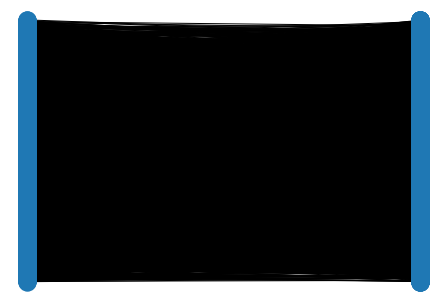

In [12]:
user_nodes = {n for n, d in B.nodes(data=True) if d["type"] == "user"}
pos = nx.bipartite_layout(B, user_nodes)
nx.draw(B, pos=pos)

In [13]:
print(len(B.nodes()))
print(len(B.edges()))

4580
8722


In [14]:
nx.write_graphml(B, "bipartitenetwork.graphml")

In [15]:
# get projection
W = bipartite.weighted_projected_graph(B, user_nodes)

In [18]:
print(len(W.nodes()))
print(len(W.edges()))

736
248390


In [19]:
# color projection
node_colors = []
for node, data in W.nodes(data=True):
    if data["leaning"] == "cottagecore":
        node_colors.append("blue")
    else:
        node_colors.append("red")

In [20]:
nx.write_graphml(W, "usernetwork.graphml")

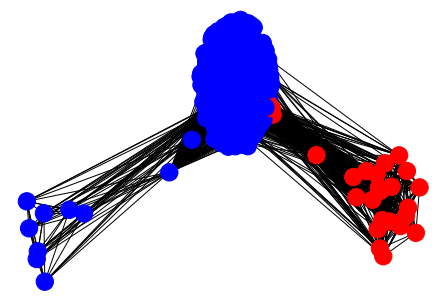

In [21]:
nx.draw(W, node_color=node_colors)

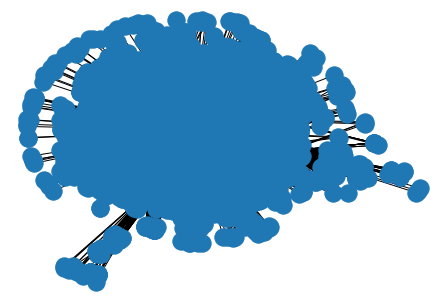

In [22]:
# other projection
tag_nodes = B.nodes() - user_nodes
W2 = bipartite.weighted_projected_graph(B, tag_nodes)
nx.draw(W2)

In [23]:
print(len(W2.nodes()))
print(len(W2.edges()))

3844
104952
